In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append("../")

from sprintdl.main import *
from sprintdl.models.efficientnet import *
from sprintdl.models.xresnet import *

device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

# Preprocess

In [24]:
import pandas as pd
import shutil
from PIL import Image
fpath = Path("/media/hdd/Datasets/faceKeypoint/")
t_path = fpath/"training.csv"
id_l = pd.read_csv(t_path)

In [25]:
id_l.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


In [26]:
for c in id_l.columns:
    if(id_l[c].dtype!='object'):
        id_l[c]=id_l[c].fillna(id_l[c].median())

In [126]:
import torchvision
import tqdm

In [127]:
def save_str_img(strimg,w,h,flpath):
    px=255-np.array(strimg.split(),dtype=float)
    if(len(px)==w*h and len(px)%w==0 and len(px)%h==0):
        cpx = list(px.reshape(w,h))
        img = torchvision.transforms.functional.to_pil_image(tensor([cpx,cpx,cpx]))
        img.save(flpath)
        return img
    else:
        raise Exception("Invalid height and width")

In [128]:
train_im_path = fpath/"trainImages"

train_im_path.mkdir(exist_ok=True)

In [132]:
id_l.shape

(7049, 31)

In [133]:
for index, train_row in tqdm.tqdm(id_l.iterrows(), total = id_l.shape[0]):
    save_str_img(train_row.Image,96,96,train_im_path/(str(index)+'.jpg'))

100%|██████████| 7049/7049 [00:18<00:00, 382.06it/s]


In [135]:
class PreProcessor():
    "Basic class for a processor that will be applied to items at the end of the data block API."
    def __init__(self, ds:Collection=None):  self.ref_ds = ds
    def process_one(self, item:Any):         return item
    def process(self, ds:Collection):        ds.items = array([self.process_one(item) for item in ds.items])


In [142]:
class PointsProcessor(PreProcessor):
    "`PreProcessor` that stores the number of targets for point regression."
    def __init__(self, ds:ItemList): self.c = len(ds.items[0].reshape(-1))
    def process(self, ds:ItemList):  ds.c = self.c

class PointsLabelList(ItemList):
    "`ItemList` for points."
    _processor = PointsProcessor
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = MSELossFlat()

    def get(self, i):
        o = super().get(i)
        return ImagePoints(FlowField(_get_size(self.x,i), o), scale=True)

    def analyze_pred(self, pred, thresh:float=0.5): return pred.view(-1,2)
    def reconstruct(self, t, x): return ImagePoints(FlowField(x.size, t), scale=False)

class PointsItemList(ImageList):
    "`ItemList` for `Image` to `ImagePoints` tasks."
    _label_cls,_square_show_res = PointsLabelList,False

# Define required

In [239]:
def pilToTensor(item):
    return torchvision.transforms.functional.pil_to_tensor(test)

In [299]:
# tfms = [make_rgb, to_byte_tensor, to_float_tensor, pilToTensor]
tfms = [make_rgb, pilToTensor]
bs = 128

In [300]:
def mloss(y_true, y_pred):
    y_true=y_true.view(-1,15,2)
    
    y_true[:,:,0]=y_true[:,:,0].clone()-y_pred[:,:,0]
    y_true[:,:,1]=y_true[:,:,1].clone()-y_pred[:,:,1]
    
    y_true[:,:,0]=y_true[:,:,0].clone()**2
    y_true[:,:,1]=y_true[:,:,1].clone()**2
    
    return y_true.sum(dim=2).sum(dim=1).sum()


In [301]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
       partial(CudaCallback, device)]

loss_func=mloss
lr = .001
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [302]:
data = PointsItemList.from_files(train_im_path, tfms = tfms)

In [303]:
data

PointsItemList (7049 items)
[PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2246.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/5325.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/4065.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/3146.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2232.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2555.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/3791.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/4444.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/5419.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2549.jpg')...]
Path: /media/hdd/Datasets/faceKeypoint/trainImages

In [304]:
# il = ImageList.from_files("/media/hdd/Datasets/imagewoof2-160/", tfms = tfms)

In [305]:
# il

In [306]:
sd = SplitData.split_by_func(data, partial(random_splitter,p_valid = .2))

In [307]:
sd

SplitData
Train: PointsItemList (5605 items)
[PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2246.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/5325.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2232.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2555.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/3791.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/4444.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/5419.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2549.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/4896.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/6913.jpg')...]
Path: /media/hdd/Datasets/faceKeypoint/trainImages
Valid: PointsItemList (1444 items)
[PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/4065.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/3146.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trai

In [308]:
def get_locs(flname):
    index = int(flname.name[:-4])
    plist=[]
    coords=list(id_l.loc[index])
    for i in range(len(coords)//2):
        plist.append([coords[i*2+1],coords[i*2]])
    return tensor(plist)

In [309]:
get_locs(Path("/media/hdd/Datasets/faceKeypoint/trainImages/2246.jpg"))

tensor([[37.4975, 65.4759],
        [37.9938, 30.4601],
        [38.4653, 58.0807],
        [39.1353, 72.8687],
        [38.9616, 38.0787],
        [39.6525, 22.3000],
        [29.2928, 56.5432],
        [30.6152, 78.5232],
        [29.3534, 38.5824],
        [31.8727, 14.7483],
        [58.4229, 48.0418],
        [78.6050, 61.7846],
        [78.8908, 33.0484],
        [77.4177, 47.4275],
        [78.8029, 47.6694]], dtype=torch.float64)

In [310]:
# sd.train.items

In [311]:
ll = label_by_func(sd, get_locs)

In [312]:
ll.train.x

PointsItemList (5605 items)
[PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2246.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/5325.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2232.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2555.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/3791.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/4444.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/5419.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/2549.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/4896.jpg'), PosixPath('/media/hdd/Datasets/faceKeypoint/trainImages/6913.jpg')...]
Path: /media/hdd/Datasets/faceKeypoint/trainImages

In [313]:
data = ll.to_databunch(bs, c_in=3, c_out=10)

In [314]:
def show_image(im, ax=None, figsize=(3, 3)):
    """
    Show single image
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis("off")
    ax.imshow(im.permute(1, 2, 0))

In [317]:
def show_batch(data, n=4, c=4, r=None, figsize=None):
    """
    Show a batch of n images from the train dataloader
    """
    x = data.train_ds.x[:n]
    if r is None:
        r = int(math.ceil(n / c))
    if figsize is None:
        figsize = (c * 3, r * 3)
    fig, axes = plt.subplots(r, c, figsize=figsize)
    for xi, ax in zip(x, axes.flat):
#         xi = torchvision.transforms.functional.pil_to_tensor(xi)
        show_image(xi, ax)

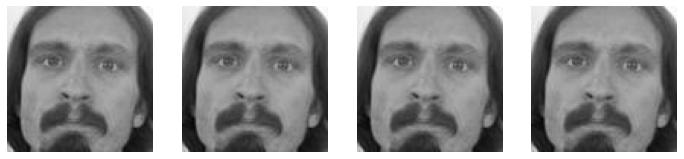

In [318]:
show_batch(data)

In [319]:
learn = Learner(get_vision_model('resnet34',1), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [320]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


RuntimeError: shape '[-1, 15, 2]' is invalid for input of size 128